# ARIMA / Autoregression

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [13]:
df = pd.read_csv('../../data/cryptocurrencypricehistory/coin_Cardano.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop('Date', axis=1).drop('SNo', axis=1)
df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2017-10-02,Cardano,ADA,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
2017-10-03,Cardano,ADA,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2017-10-04,Cardano,ADA,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
2017-10-05,Cardano,ADA,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
2017-10-06,Cardano,ADA,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


Text(0.5, 1.0, 'Lag Plot (Log Close Price)')

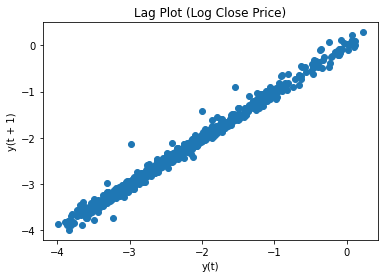

In [16]:
pd.plotting.lag_plot(np.log(df['Close']))
plt.title('Lag Plot (Log Close Price)')

The correlation in the lag plot (lag 1) suggests that an autoregressive model is appropriate.

Text(0.5, 1.0, 'Autocorrelation Plot (Log Close Price)')

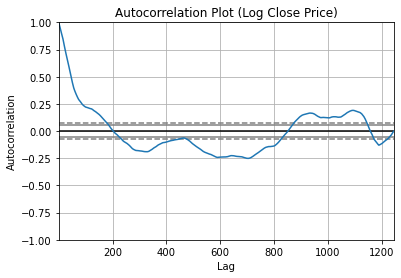

In [17]:
pd.plotting.autocorrelation_plot(np.log(df['Close']))
plt.title('Autocorrelation Plot (Log Close Price)')

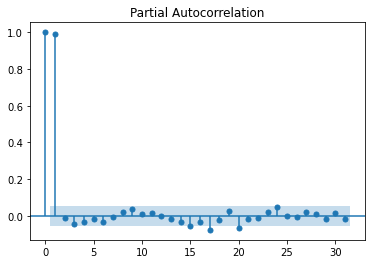

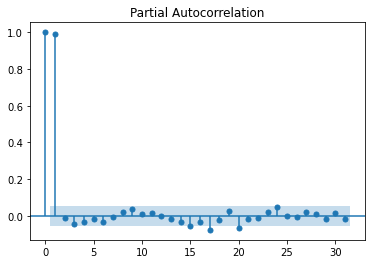

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Close'].apply(np.log))

## Check Stationarity

In [466]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Close'].values)
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

ADF-Statistic: -0.7128723298932104
p-value: 0.8433870805859085
Critical Values {'1%': -3.435716995109265, '5%': -2.8639100200710828, '10%': -2.568031835031368}


This suggests that the close price of ADA is not stationary. Perhaps the model should be differenced.

<AxesSubplot:xlabel='Date'>

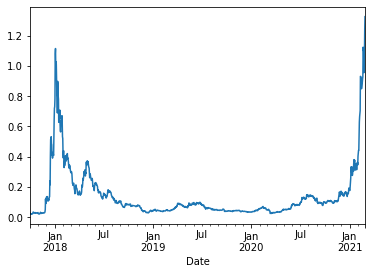

In [463]:
df['Close'].plot()

<AxesSubplot:xlabel='Date'>

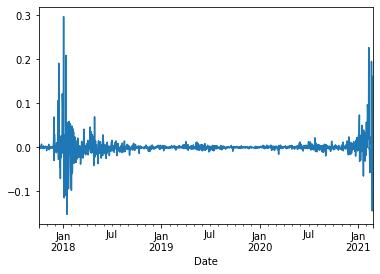

In [464]:
#pandas series.diff()
df['Close'].diff().fillna(0).plot()

In [465]:
adf_test = adfuller(df['Close'].diff.dropna().values)
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

NameError: name 'adfuller' is not defined

Now the ADF test results show that the data is now stationary. However, this manual differencing may not need to be done if an ARIMA model is used. The ADF test may not specifically show stationarity, so another test can be done, the KPSS test.

In [49]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df['Close'].apply(np.log).values) 
print('KPSS-Statistic:',kpss_test[0])
print('p-value:',kpss_test[1])
print('Critical Values', kpss_test[3])

KPSS-Statistic: 0.6615722111436381
p-value: 0.017038889896032902
Critical Values {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [50]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df['Close'].apply(np.log).diff().dropna().values) 
print('KPSS-Statistic:',kpss_test[0])
print('p-value:',kpss_test[1])
print('Critical Values', kpss_test[3])

KPSS-Statistic: 0.21929158236343502
p-value: 0.1
Critical Values {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Time Series Decomposition

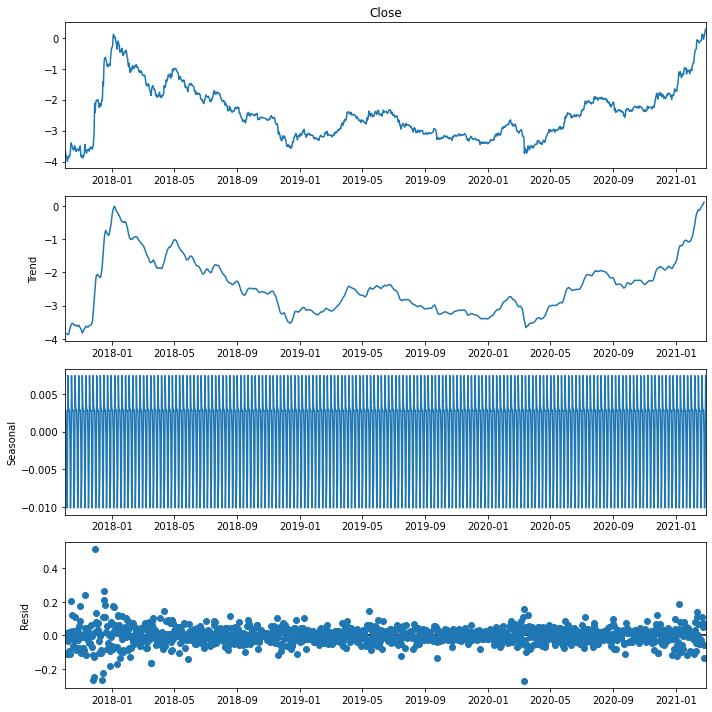

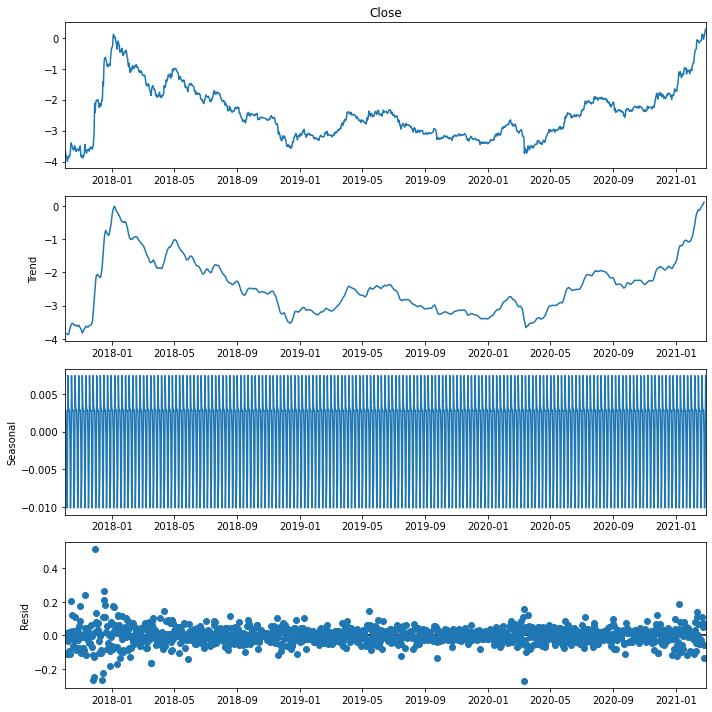

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'].apply(np.log), model='additive')
plt.rc("figure", figsize=(10,10))
result.plot()

## Autoregression

In [521]:
from statsmodels.tsa.ar_model import AutoReg
X = df['Close'].apply(np.log).values
forecast = 7
X_train, X_test = X[1:len(X)-forecast], X[len(X)-forecast:]

Calculate the hit rate, which is the number of days for which the model predicts the return of the price (up or down for the day) correctly. 

In [522]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

In [523]:
def hit_rate_diff(true, pred):
    hits = []
    is_same = lambda x,y: 1 if np.sign(x)==np.sign(y) else 0
    for t in range(len(true)-1):
        hits.append(is_same(true[t], pred[t]))
    rate = 1 - sum(hits)/len(hits)
    return rate

In [524]:
rates = []
for lag in range(1,int(len(X_train)/2)-1):
    autoreg = AutoReg(X, lags=lag, old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    rates.append(hit_rate(X_test, X_hat))

In [525]:
max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]

In [537]:
mses = []
for lag in range(1,int(len(X_train)/2)-1):
    autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    mses.append(mean_squared_error(X_test, X_hat))

In [540]:
min_mse_lags = [i for i, j in enumerate(mses) if j == min(mses)]
min(mses)

0.0069726467571437625

In [536]:
autoreg = AutoReg(X_train, lags=min_mse_lags[0], old_names=True).fit()
X_hat = autoreg.forecast(forecast)

Lag: 467
Hit rate: 0.8333333333333334
Mean Squared Error: 0.010655333310444525


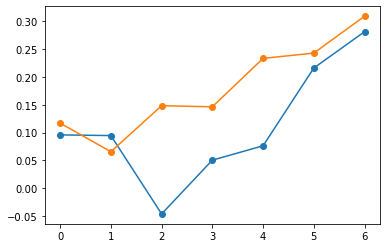

In [529]:
plt.plot(X_test, marker='o')
plt.plot(X_hat, marker='o')
print("Lag:", min_mse_lags[0])
print("Hit rate:", rates[min_mse_lags[0]])
print("Mean Squared Error:", min(mses))

In [ ]:
def 

## Vector Autoregression

In [422]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [443]:
X = df.drop('Volume', axis=1).iloc[:,2:].diff().values
forecast = 30
X_train, X_test = X[1:len(X)-forecast], X[len(X)-forecast:]

In [444]:
varmod = VAR(X_train)
varmod_fit = varmod.fit(20)
X_hat = varmod_fit.forecast(X_train, forecast)

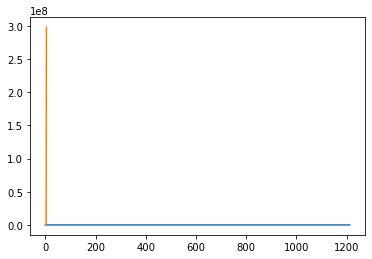

In [445]:
plt.plot(X_train[:,3])
plt.plot(X_hat[3])

In [156]:
lag_order = varmod_fit.k_ar
forecast_data = X[-lag_order:]

X_hat = varmod_fit.forecast(y=forecast_data, steps=forecast)
X_hat_df = (pd.DataFrame(X_hat, index=df.index[-forecast:], columns= df.drop('Volume', axis=1).iloc[:,2:].columns + '_pred'))
X_hat_df

,High_pred,Low_pred,Open_pred,Close_pred,Marketcap_pred
Date,,,,,
2021-01-29,0.007718,-0.000294,-0.003177,0.026687,0.026739
2021-01-30,0.014953,0.024634,0.026663,-0.001676,-0.001626
2021-01-31,0.002400,-0.012247,-0.001623,0.006787,0.006838
2021-02-01,0.006342,0.013008,0.006753,0.001374,0.001424
2021-02-02,0.004514,-0.002058,0.001432,0.006964,0.007014
2021-02-03,0.006434,0.008766,0.006966,0.002549,0.002599
2021-02-04,0.004753,0.000347,0.002587,0.005414,0.005465
2021-02-05,0.005855,0.006471,0.005426,0.003428,0.003478
2021-02-06,0.005116,0.002156,0.003460,0.004910,0.004961


In [171]:
df_train = df.drop('Volume', axis=1).iloc[:,2:][:-forecast]
# inverting transformation
def invert_transformation(df_tr_diff, pred):
    forecast = pred.copy()
    columns = df_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df.drop('Volume', axis=1).iloc[:,2:][:-forecast].diff(), X_hat_df)
output.head()

,High_pred,Low_pred,Open_pred,Close_pred,Marketcap_pred
Date,,,,,
2021-01-29,33858.318710,30023.206538,30441.038639,33466.123045,6.229101e+11
2021-01-30,33858.333664,30023.231171,30441.065303,33466.121369,6.229101e+11
2021-01-31,33858.336064,30023.218924,30441.063680,33466.128156,6.229101e+11
2021-02-01,33858.342406,30023.231932,30441.070434,33466.129530,6.229101e+11
2021-02-02,33858.346920,30023.229875,30441.071865,33466.136493,6.229101e+11


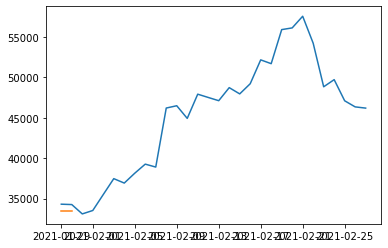

In [181]:
plt.plot(df['Close'][-30:])
plt.plot(output['Close_pred'][:2])

## Autoregressive Integrated Moving Average (ARIMA)

In [325]:
from statsmodels.tsa.arima.model import ARIMA
#X = df.drop('Close', axis=1).iloc[:,2:].apply(np.log).values
X = df['Close'].apply(np.log).values
forecast = 30
X_train, X_test = X[0:len(X)-forecast], X[len(X)-forecast:]

In [326]:
arima_mod = ARIMA(X_train, order=(1,1,0), dates=df.index.values, freq='D', trend='t')
arima_mod_fit = arima_mod.fit()

In [327]:
X_hat = arima_mod_fit.forecast(forecast)
X_hat

array([10.41903463, 10.42097238, 10.42289507, 10.42481795, 10.42674083,
       10.42866371, 10.43058659, 10.43250947, 10.43443235, 10.43635523,
       10.43827811, 10.44020098, 10.44212386, 10.44404674, 10.44596962,
       10.4478925 , 10.44981538, 10.45173826, 10.45366114, 10.45558402,
       10.4575069 , 10.45942978, 10.46135265, 10.46327553, 10.46519841,
       10.46712129, 10.46904417, 10.47096705, 10.47288993, 10.47481281])

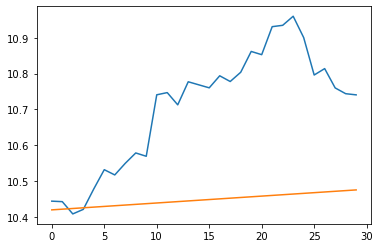

In [328]:
plt.plot(X_test)
plt.plot(X_hat)

## VARMA

In [107]:
from statsmodels.tsa.statespace.varmax import VARMAX
X = df.drop('Volume', axis=1).iloc[:,2:].apply(np.log).values
forecast = 30
X_train, X_test = X[1:len(X)-forecast], X[len(X)-forecast:]

In [108]:
varmod = VARMAX(X_train, dates=df.index.values, freq='D', enforce_invertibility=False)
varmod_fit = varmod.fit()
varmod_fit.summary()

Dep. Variable:,"['y1', 'y2', 'y3', 'y4', 'y5']",No. Observations:,2831
Model:,VAR(1),Log Likelihood,50599.645
,+ intercept,AIC,-101109.290
Date:,"Mon, 03 May 2021",BIC,-100841.613
Time:,22:41:08,HQIC,-101012.723
Sample:,04-29-2013,,
,- 02-27-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.99, 5.99, 5.38, 0.01, 0.87",Jarque-Bera (JB):,"23349.40, 129811.54, 2912732.00, 21297.83, 246683050.12"
Prob(Q):,"0.16, 0.01, 0.02, 0.93, 0.35",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.62, 0.47, 0.23, 0.49, 0.14",Skew:,"2.53, -4.05, 6.15, 0.10, -31.13"


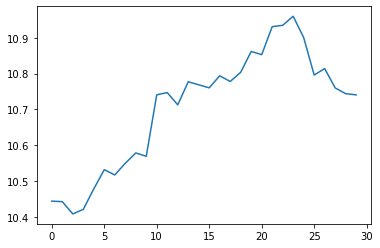

In [134]:
plt.plot(X_test[:,3])